# Importing libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from scipy.sparse import csr_matrix
import pickle
# import cv2 as cv
# import time

# Defining paths

In [2]:
cur_dir = 'C:/Users/cortiz/Projects/inscopix_project_cajal/data/20211204/mouse_02_IL'
path_table = os.path.join(cur_dir, 'behavior', 'table_cut.csv')
path_mat_spikes = os.path.join(cur_dir, 'spikes', 'finalSpikesMat.mat')

# Parameters

In [3]:
framerate_inscopix = 20
framerate_behavior = 15
frame_count = np.array([4015, 3709, 3872, 3715, 3737, 3752, 4344, 3698, 4628, 3801, 3770, 3774])
discard_sessions = np.array([8,9])
dict_env = {'t_maze': [0, 3, 6],
            'y_maze': [1, 4, 7, 8],
            'open_field': [2, 5, 9]}

# Loading files

In [5]:
path_pickle = os.path.join(cur_dir, 'pickle')
with open(os.path.join(path_pickle, 'meta_spikes.pck'), 'rb') as f:
    meta_spikes = pickle.load(f)
with open(os.path.join(path_pickle, 'df_dlc.pck'), 'rb') as f:
    df_dlc = pickle.load(f)
with open(os.path.join(path_pickle, 'mat_spikes.pck'), 'rb') as f:
    mat_spikes = pickle.load(f)
with open(os.path.join(path_pickle, 'df_frames.pck'), 'rb') as f:
    df_frames = pickle.load(f)

### Checking offset between recordings

# Plotting spatial activity

In [83]:
path_plot = cur_dir + '/plots/session_colored'
os.makedirs(path_plot, exist_ok=True)

sorted_cells_decreasing = np.argsort(-np.sum(mat_spikes, axis = 0))

ncol = 4
nrow = int(np.ceil(len(df_frames)/ncol))

for cur_cell in sorted_cells_decreasing[:15]:
    plt.figure(figsize = (5*ncol, 5*nrow))
    spike_train = np.where(mat_spikes[:, cur_cell])[0]

    for i,r in df_frames.iterrows():
        cur_session = r['session']
        plt.subplot(nrow, ncol, i+1)
        sub_spikes = meta_spikes.query('session == @cur_session')
        cur_spikes = spike_train[[s in sub_spikes.index for s in spike_train]]
        plt.title(cur_session)
        plt.plot(sub_spikes['x'], sub_spikes['y'], c = 'lightgray', alpha = 0.5, linewidth = 0.5)
        plt.scatter(meta_spikes['x'][cur_spikes], meta_spikes['y'][cur_spikes])
        plt.gca().set_aspect('equal')
        
    plt.savefig(path_plot + '/activity_overview_cell_' + str(cur_cell).zfill(3) + '.png', dpi = 300)
    plt.close()

In [84]:
path_plot = cur_dir + '/plots/session_colored'
sorted_cells_decreasing = np.argsort(-np.sum(mat_spikes, axis = 0))

ncol = 3
nrow = 1

for cur_cell in sorted_cells_decreasing[:15]:
    
    plt.figure(figsize = (5*ncol, 5*nrow))
    spike_train = np.where(mat_spikes[:, cur_cell])[0]
    cnt_plt = 0
    
    for k, selected_sessions in dict_env.items():
        
        cnt_plt += 1
        plt.subplot(nrow, ncol, cnt_plt)
        plt.title(cur_session)
        plt.gca().set_aspect('equal')
        
        lname = list()
        for idx in selected_sessions:
            lname.append(df_frames.loc[idx, 'session'])

        for i,r in df_frames.iterrows():
            if r['session'] not in lname:
                continue
            
            cur_session = r['session']
            sub_spikes = meta_spikes.query('session == @cur_session')
            cur_spikes = spike_train[[s in sub_spikes.index for s in spike_train]]
            plt.plot(sub_spikes['x'], sub_spikes['y'], c = 'lightgray', alpha = 0.5, linewidth = 0.5)
            plt.scatter(meta_spikes['x'][cur_spikes], meta_spikes['y'][cur_spikes])
        
    plt.savefig(path_plot + '/activity_env_merged_cell_' + str(cur_cell).zfill(3) + '.png', dpi = 300)
    plt.close()

# Running plots

## Computing running speed

In [40]:
df_dlc['speed'] = 0
session_list = pd.unique(df_dlc['session'])
for sess in session_list:
    cur_df = df_dlc.query('session == @sess')
    for idx in cur_df.index[1:-1]:
        xdiff = df_dlc.loc[idx+1, 'xc'] - df_dlc.loc[idx-1, 'xc']
        ydiff = df_dlc.loc[idx+1, 'yc'] - df_dlc.loc[idx-1, 'yc']
        dist = np.sqrt(np.power(xdiff,2) + np.power(ydiff,2))
        time = (1/framerate_behavior)
        df_dlc.loc[idx, 'speed'] = dist/time

## Deciding of a threshold

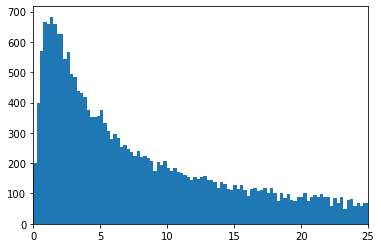

In [59]:
threshold_max_speed = 250
threshold_running = 12
speed_list = df_dlc['speed']
speed_list = speed_list[speed_list < threshold_max_speed]
_ = plt.hist(speed_list, 1000)
plt.xlim(0, 25)
df_dlc['is_running'] = df_dlc['speed'] > threshold_running

## Coloring based on running speed

In [82]:
path_plot = cur_dir + '/plots/speed_colored'
os.makedirs(path_plot, exist_ok=True)

sorted_cells_decreasing = np.argsort(-np.sum(mat_spikes, axis = 0))
ncol = 3
nrow = 1

for cur_cell in sorted_cells_decreasing[:15]:
    
    plt.figure(figsize = (5*ncol, 5*nrow))
    spike_train = np.where(mat_spikes[:, cur_cell])[0]
    cnt_plt = 0
    
    for k, selected_sessions in dict_env.items():
        
        cnt_plt += 1
        plt.subplot(nrow, ncol, cnt_plt)
        plt.title(cur_session)
        plt.gca().set_aspect('equal')
        
        lname = list()
        for idx in selected_sessions:
            lname.append(df_frames.loc[idx, 'session'])

        for i,r in df_frames.iterrows():
            if r['session'] not in lname:
                continue
            
            cur_session = r['session']
            sub_spikes = meta_spikes.query('session == @cur_session')
            cur_spikes = spike_train[[s in sub_spikes.index for s in spike_train]]
            plt.plot(sub_spikes['x'], sub_spikes['y'], c = 'lightgray', alpha = 0.5, linewidth = 0.5)
            
            for _,r in meta_spikes.loc[cur_spikes].iterrows():
                col_plot = 'green' if df_dlc.loc[r['behavioral_frame'], 'is_running'] else 'red'
                plt.scatter(r['x'], r['y'], c = col_plot)
        
    plt.savefig(path_plot + '/activity_env_merged_cell_' + str(cur_cell).zfill(3) + '.png', dpi = 300)
    plt.close()